# Camera analysis by user rough

In [56]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import shapiro
from scipy.stats import probplot
from tabulate import tabulate
from scipy.stats import zscore
from scipy.stats import friedmanchisquare

conn = sqlite3.connect(
    r"C:\Users\max-j\OneDrive\Desktop\Bachelorarbeit_Auswertung\Datenbanken\Auswertung\app_database_2")

queryDataCombinedAvg = """SELECT
                            *
                          FROM DistancesPerTestCaseRough;"""

observed_group = 'UserID'
tested_variable = 'CameraDistance'

DataCombinedAvg = pd.read_sql_query(queryDataCombinedAvg, conn)
DataCombinedAvgAggregated = DataCombinedAvg.groupby([observed_group, 'ScenarioCase'])['CameraDistance'].mean().reset_index()

DataCombinedAvgAggregated[f'{tested_variable}_z_within'] = DataCombinedAvgAggregated.groupby('ScenarioCase')[tested_variable].transform(zscore)


for data in DataCombinedAvgAggregated[f'{tested_variable}_z_within']:
    if data >= 2.5 or data <= -2.5:
        print(f"Significant outlier {data}")

               count      mean       std       min       25%       50%  \
ScenarioCase                                                             
FOLDAR          12.0  3.980682  1.556059  1.282245  3.028772  4.155443   
FOLDAROPEN      12.0  3.937526  1.784541  1.455905  2.409617  4.074423   
STATEOFTHEART   12.0  5.100074  2.758422  1.228526  2.993826  5.144852   

                    75%        max  
ScenarioCase                        
FOLDAR         4.823584   6.431367  
FOLDAROPEN     5.460114   6.838187  
STATEOFTHEART  5.872492  10.734062  


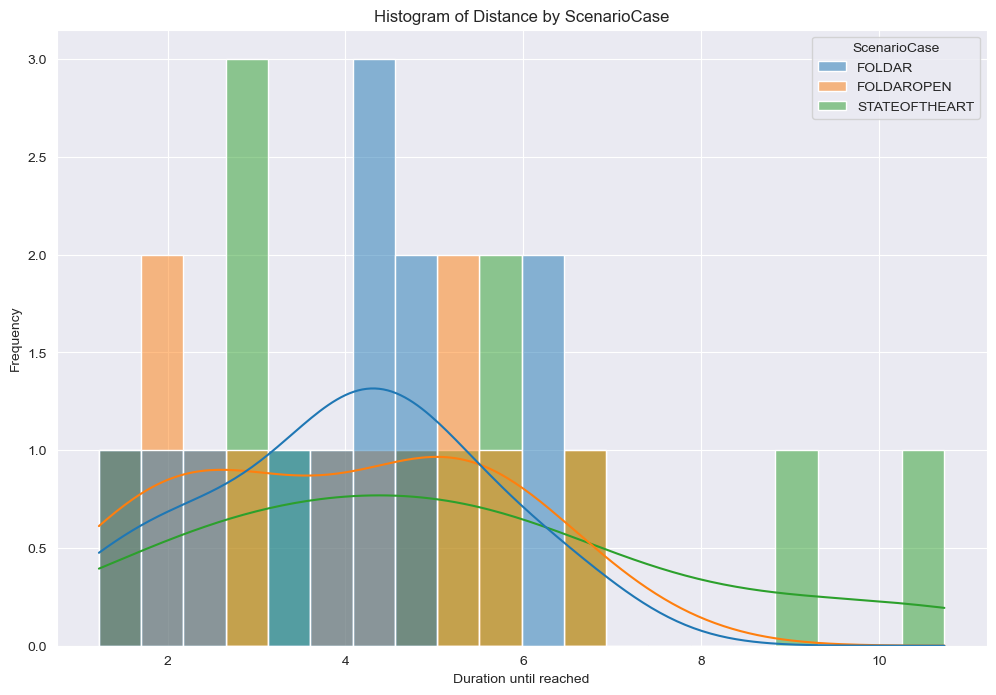

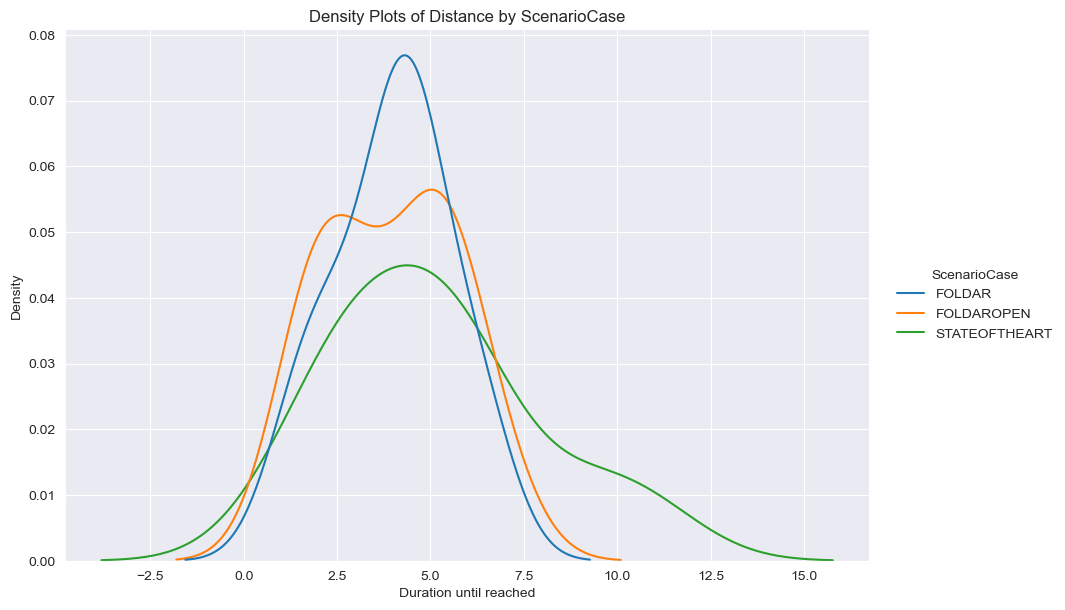

In [57]:
#Average duration for each scenario
summary_stats = DataCombinedAvgAggregated.groupby('ScenarioCase')[tested_variable].describe()
DataUserScenario = DataCombinedAvgAggregated.groupby('ScenarioCase')[["CameraDistance"]].mean().reset_index()
# Falls summary_stats den Index "ScenarioCase" hat,
# setze bei DataUserScenario "ScenarioCase" als Schlüssel.
combined_output = pd.merge(
    summary_stats.reset_index(),  # falls summary_stats als Index ScenarioCase hat
    DataUserScenario,
    on='ScenarioCase',
    how='outer'
)
print(summary_stats)

plt.figure(figsize=(12, 8))
sns.histplot(data=DataCombinedAvgAggregated, x=tested_variable, hue="ScenarioCase", kde=True, bins=20, alpha=0.5)
plt.title('Histogram of Distance by ScenarioCase')
plt.xlabel("Duration until reached")
plt.ylabel("Frequency")
plt.show()

sns.displot(data=DataCombinedAvgAggregated, x=tested_variable, hue='ScenarioCase', kind="kde", height=6, aspect=1.5)
plt.title("Density Plots of Distance by ScenarioCase")
plt.xlabel("Duration until reached")
plt.ylabel("Density")
plt.show()

# Check for normality

Shapiro-Wilk Normality Test Results per ScenarioCase:
Scenario: FOLDAR          | Shapiro-Wilk Statistic: 0.964681 | p-value: 0.847953
Scenario: FOLDAROPEN      | Shapiro-Wilk Statistic: 0.937533 | p-value: 0.466792
Scenario: STATEOFTHEART   | Shapiro-Wilk Statistic: 0.936751 | p-value: 0.457168


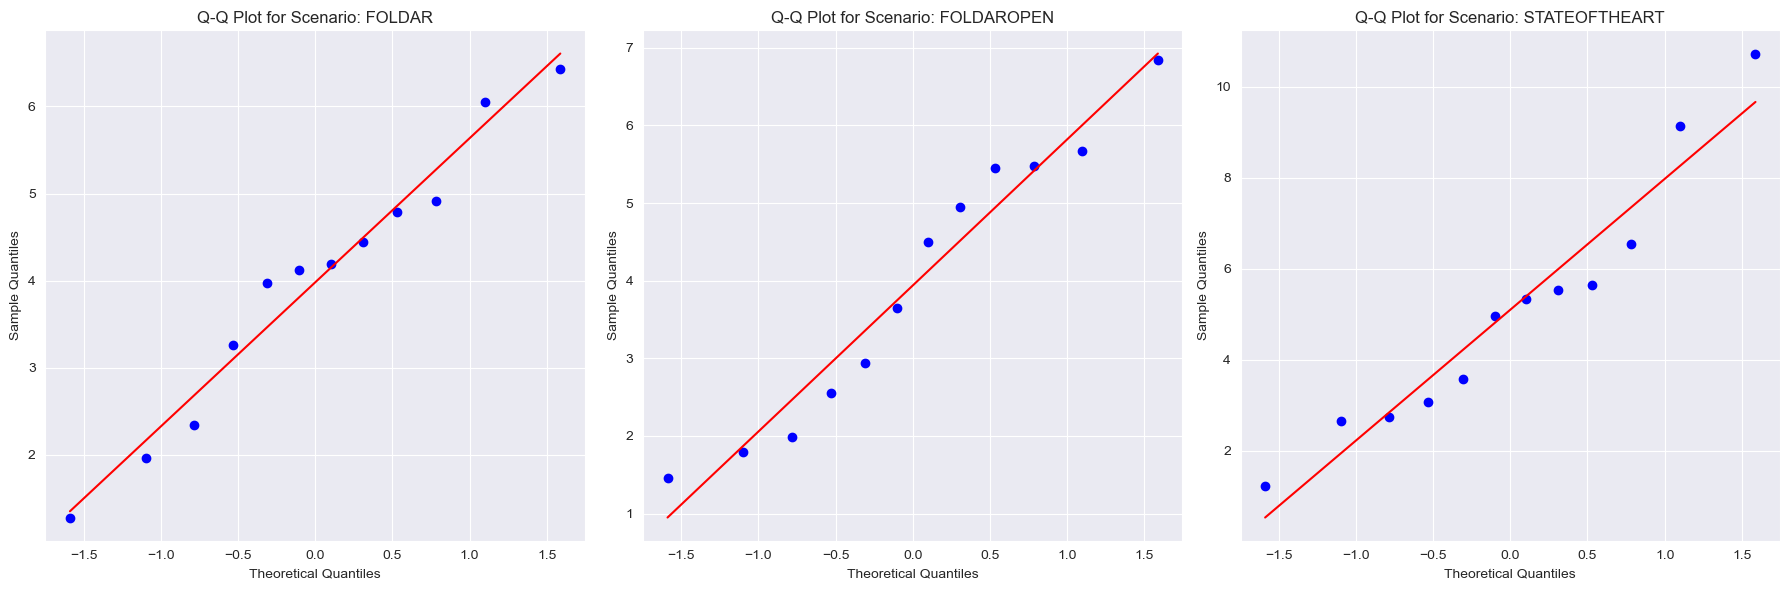

In [58]:
print("Shapiro-Wilk Normality Test Results per ScenarioCase:")
for scenario in DataCombinedAvgAggregated['ScenarioCase'].unique():
    data_scenario = DataCombinedAvgAggregated.loc[DataCombinedAvgAggregated['ScenarioCase'] == scenario, tested_variable]
    stat, p_value = shapiro(data_scenario)
    print(f"Scenario: {scenario:<15} | Shapiro-Wilk Statistic: {stat:.6f} | p-value: {p_value:.6f}")

# Get unique scenarios
scenarios = DataCombinedAvgAggregated['ScenarioCase'].unique()
n_scenarios = len(scenarios)

# Create a subplot grid. For example, one row with n_scenarios columns:
fig, axs = plt.subplots(1, n_scenarios, figsize=(6 * n_scenarios, 6))

# In case there's only one scenario, wrap the ax in a list
if n_scenarios == 1:
    axs = [axs]

# Loop over each scenario and respective subplot axis
for ax, scenario in zip(axs, scenarios):
    data_to_plot = DataCombinedAvgAggregated.loc[DataCombinedAvgAggregated['ScenarioCase'] == scenario, tested_variable]
    probplot(data_to_plot, dist="norm", plot=ax)
    ax.set_title(f"Q-Q Plot for Scenario: {scenario}")
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles")

plt.tight_layout()
plt.show()

# Mauchlys Test

In [59]:
sphericity_results = pg.sphericity(DataCombinedAvgAggregated, dv=tested_variable, within='ScenarioCase',
                                   subject=observed_group, method='mauchly', alpha=0.05)

header = f"{'Spher':<10} {'W':<15} {'Chi2':<15} {'Dof':<10} {'P-Value':<15}"
print("\nMauchly's Test for Sphericity Results:")
print(header)
print("-" * len(header))

row = f"{str(sphericity_results.spher):<10} " \
      f"{sphericity_results.W:<15.6f} " \
      f"{sphericity_results.chi2:<15.6f} " \
      f"{sphericity_results.dof:<10} " \
      f"{sphericity_results.pval:<15.6f}"
print(row)


Mauchly's Test for Sphericity Results:
Spher      W               Chi2            Dof        P-Value        
---------------------------------------------------------------------
True       0.953182        0.479491        2          0.786828       


# Repeated Anova


Repeated Measures ANOVA Results:

+--------------+---------+------+---------+-----------+------------+------------+------------+
| Source       |      SS |   DF |      MS |         F |      p-unc |        ng2 |        eps |
|--------------+---------+------+---------+-----------+------------+------------+------------|
| ScenarioCase | 10.4257 |    2 | 5.21283 |   2.26844 |   0.127145 |   0.066922 |   0.955276 |
| Error        | 50.5555 |   22 | 2.29798 | nan       | nan        | nan        | nan        |
+--------------+---------+------+---------+-----------+------------+------------+------------+


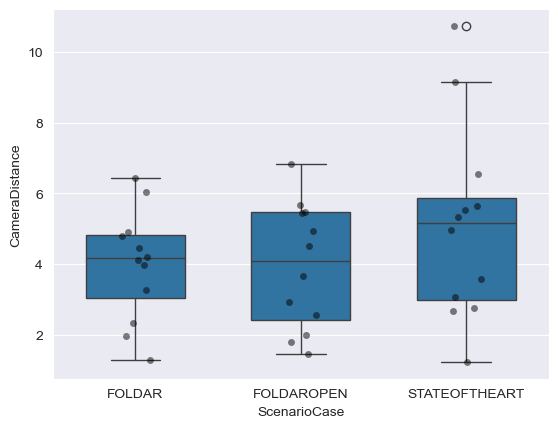

In [60]:
rm_anova = pg.rm_anova(data=DataCombinedAvgAggregated,
                       dv=tested_variable,
                       subject=observed_group,
                       within=['ScenarioCase'],
                       detailed=True)

# Print results
print("\nRepeated Measures ANOVA Results:\n")
print(tabulate(rm_anova, headers='keys', tablefmt='psql', showindex=False))

sns.boxplot(data=DataCombinedAvgAggregated, x='ScenarioCase', y=tested_variable, width=0.6, showfliers=True)
sns.stripplot(data=DataCombinedAvgAggregated, x='ScenarioCase', y=tested_variable, color='black', alpha=0.5)
plt.show()

# Visualizing the Data

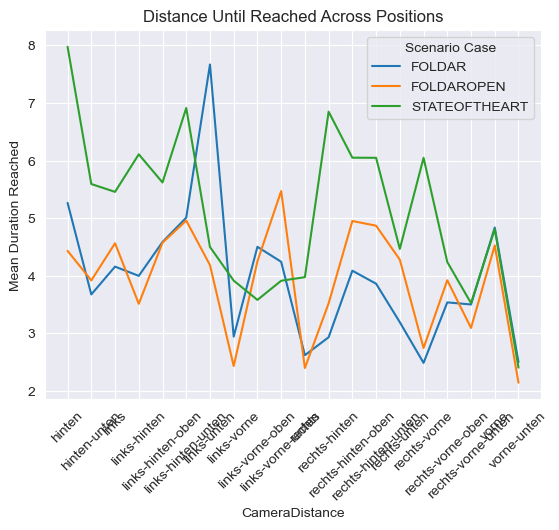

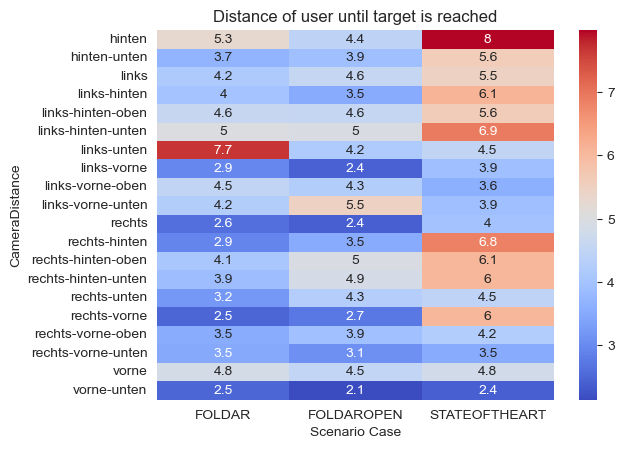

In [61]:
for scenario in DataCombinedAvg['ScenarioCase'].unique():
    scenario_data = DataCombinedAvg[DataCombinedAvg['ScenarioCase'] == scenario]
    means = scenario_data.groupby('Position')[tested_variable].mean()
    plt.plot(means.index, means.values, label=scenario)

plt.title("Distance Until Reached Across Positions")
plt.xlabel(tested_variable)
plt.ylabel("Mean Duration Reached")
plt.legend(title="Scenario Case")
plt.xticks(rotation=45)
plt.show()


pivot_data = DataCombinedAvg.pivot_table(index='Position', columns='ScenarioCase', values=tested_variable,
                                         aggfunc='mean')
sns.heatmap(pivot_data, annot=True, cmap='coolwarm')
plt.title("Distance of user until target is reached")
plt.xlabel("Scenario Case")
plt.ylabel(tested_variable)
plt.show()